# 2.7

In [81]:
import ugradio
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import astropy
import time
import astropy.units as u

In [82]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern Roman']
rcParams['font.size'] = 12

In [2]:
def PS(x, divisor):
    """Takes in a complex array and outputs a plot of frequency versus power spectrum."""

    Vsamp = 62.5/divisor
    N = 16000
    
    a = x[:len(x)/2]
    b = x[len(x)/2:]
    c = a + b * 1j

    time = np.linspace(-N/(2*Vsamp),(N/2-1)/Vsamp,N)
    
    f,fx = ugradio.dft.dft(c[:N],t=time, vsamp=Vsamp)
    P = np.abs(fx)**2
    plt.plot(f,P)
    plt.xlabel("Frequency")
    plt.ylabel("Power [volt-second^2]")
    plt.show()

In [3]:
def avg_ps(data, n=1000):
    """Takes in a dualmode dataset of n blocks -- 16000 samples each -- and returns a power spectrum averaged over all blocks.
    
    Parameters
    ----------
    data : dual-mode data taken from pico sampler, loaded as an array
    n : number of blocks of data taken

    Returns
    -------
    avg_power : average power spectrum of n blocks of complex data"""
    
    real = data[:len(data)/2]
    imag = data[len(data)/2:len(data)]
    complex_data = real + (imag * 1j)
   
    power_blocks = [] # total len = n, item len = 16000

    for i in range(n):
        x = complex_data[i * 16000 : 16000 * (i + 1)]
        voltage = np.fft.fft(x)
        power = np.abs(voltage)**2
        power_blocks.append(power)
         
    avg_power = sum(power_blocks) / len(power_blocks)
    return(avg_power)

In [4]:
def smooth(data):
    """Reduces noise in a spectrum by averaging over 3 channels. Slightly degrades spectral resolution.
    
    Parameters
    ----------
    data : power spectrum
    
    Returns
    -------
    smooth : smoothed power spectrum"""
    
    smooth = [data[0]]

    for i in range(1, len(data)):
        if i < len(data):
            span = data[i-1:i+1]
            smooth_value = np.mean(span)
            smooth.append(smooth_value)
        else:
            smooth.append(data[len(data)])
    return smooth

## Taking a Suitable Average

### Changing First LO

LO for upper baseband: 1231 MHz

LO for lower baseband: 1229 MHz

Power of LO: 13 dBm

x = ugradio.pico.capture_data('50mV', divisor=8, dual_mode=True, nsamples=16000, nblocks=1000)

np.save('upper_block_n', x)

Took data 10 times resulting in 10,000 total blocks. Repeated for lower.

In [5]:
upper = [avg_ps(np.load(f), 1000) for f in glob.glob('upper_block_*.npy')]

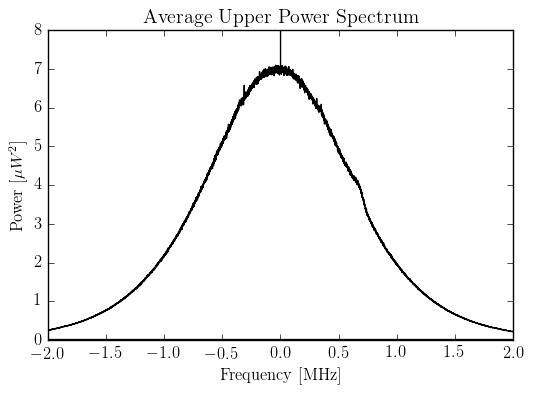

In [118]:
avg_upper = sum(upper) / len(upper)
frequency = np.fft.fftfreq(len(avg_upper), 1/(62.5/8))

plt.plot(frequency, smooth(avg_upper/10**12), 'k-')
plt.title('Average Upper Power Spectrum')
plt.xlabel('Frequency [MHz]')
plt.xlim(-2, 2)
plt.ylim(0, 8)
plt.ylabel('Power [\mu W^2]')
plt.show()

In [20]:
lower = [avg_ps(np.load(f),1000) for f in glob.glob('lower_block_*.npy')]

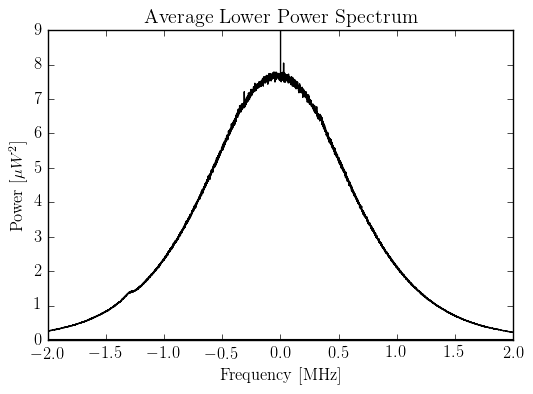

In [119]:
avg_lower = sum(lower) / len(lower)
frequency = np.fft.fftfreq(len(avg_lower), 1/(62.5/8))

plt.plot(frequency, smooth(avg_lower/10**12), 'k-')
plt.title('Average Lower Power Spectrum')
plt.xlabel('Frequency [MHz]')
plt.xlim(-2, 2)
plt.ylim(0, 9)
plt.ylabel('Power [\mu W^2]')
plt.show()

## Line Shape

In [40]:
s_on = avg_upper
s_off = avg_lower

s_line = s_on/s_off

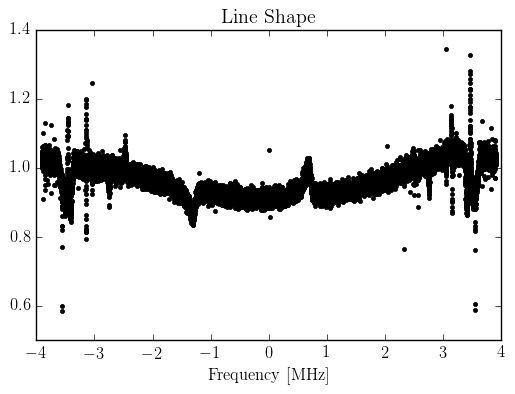

In [56]:
frequency = np.fft.fftfreq(len(s_line), 1/(62.5/8))
plt.plot(frequency, s_line, 'k.')
plt.title('Line Shape')
plt.xlabel('Frequency [MHz]')
plt.show()

## Line Intensity

In [43]:
T_cold = 3 # K
T_cal = 300 # K

In [44]:
Vsamp = 62.5/8
N = 16000
time = np.linspace(-N/(2*Vsamp),(N/2-1)/Vsamp,N)

cold = np.loadtxt('sCold-2-24-19.txt')
a_cold = cold[:len(cold)/2]
b_cold = cold[len(cold)/2:]
c_cold = a_cold + b_cold * 1j
f,fx = ugradio.dft.dft(c_cold[:N],t=time, vsamp=Vsamp)
P_cold = np.abs(fx)**2

cal = np.loadtxt('sPerson-2-24-19.txt')
a_cal = cal[:len(cal)/2]
b_cal = cal[len(cal)/2:]
c_cal = a_cal + b_cal * 1j
f,fx = ugradio.dft.dft(c_cal[:N],t=time, vsamp=Vsamp)
P_cal = np.abs(fx)**2

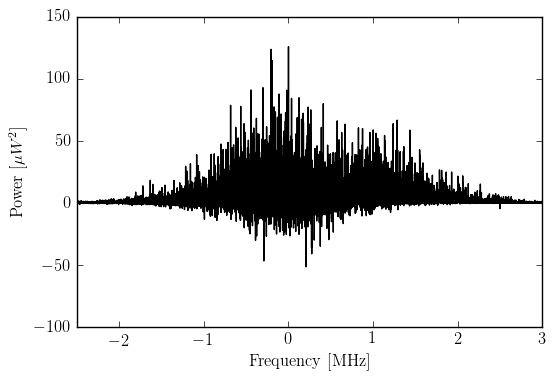

In [59]:
plt.plot(f, (P_cal - P_cold)/10**12, 'k')
# plt.title('Person - Sky')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Power [\mu W^2]')
plt.xlim(-2.5, 3)
plt.show()

In [12]:
# obtain gain

G = (T_cal - T_cold)/(np.sum(P_cal - P_cold)) * np.sum(P_cold)
print(G)

126.34495924


In [48]:
G = 126.34495924
T_line = s_line * G

## Plot Intensity vs. Frequency -- and Velocity

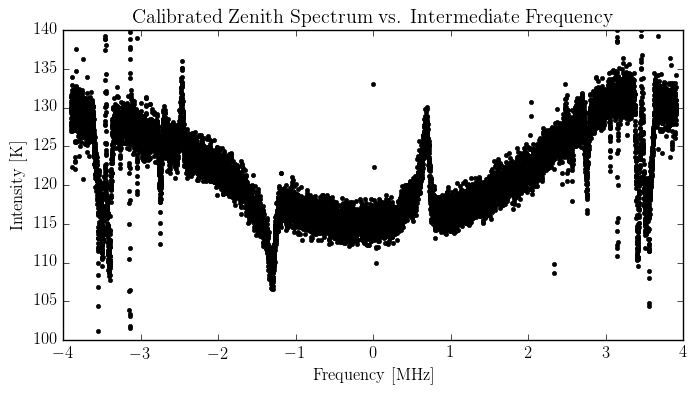

In [104]:
frequency = np.fft.fftfreq(len(T_line), 1/(62.5/8))

plt.figure(figsize=(8,4))
plt.plot(frequency, smooth(T_line), 'k.')
plt.title('Calibrated Zenith Spectrum vs. Intermediate Frequency')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity [K]')
plt.ylim(100, 140)
plt.show()

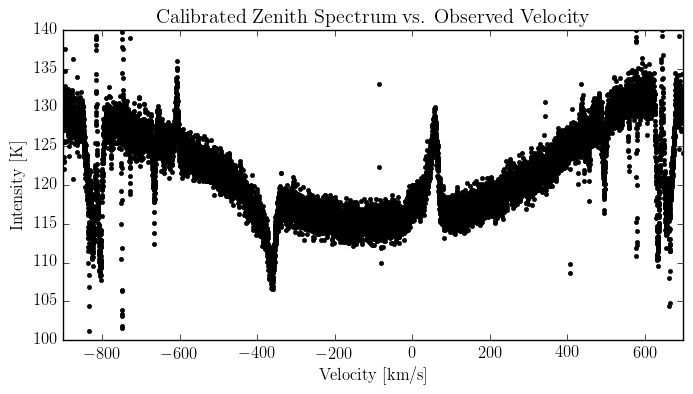

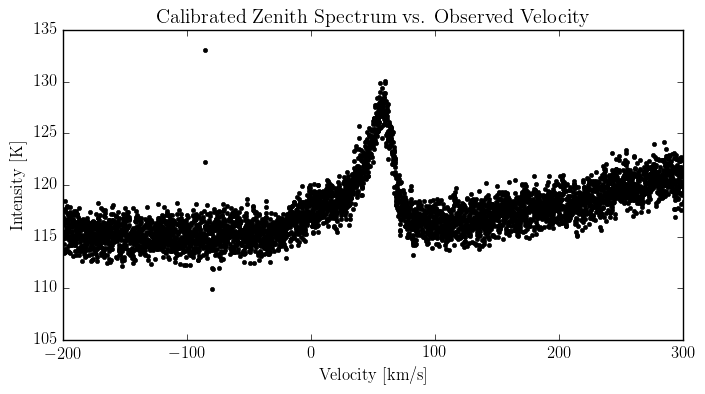

In [133]:
frequency = np.fft.fftfreq(len(T_line), 1/(62.5/8))

c = 299792.458 #km/s
f_0 = 1420.4058 # MHz
velocity = c * (frequency - 0.4058)/f_0

plt.figure(figsize=(8,4))
plt.plot(velocity, smooth(T_line), 'k.')
plt.title('Calibrated Zenith Spectrum vs. Observed Velocity')
plt.xlabel('Velocity [km/s]')
plt.ylabel('Intensity [K]')
plt.xlim(-900, 700)
plt.ylim(100, 140)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(velocity, smooth(T_line), 'k.')
plt.title('Calibrated Zenith Spectrum vs. Observed Velocity')
plt.xlabel('Velocity [km/s]')
plt.ylabel('Intensity [K]')
plt.xlim(-200, 300)
plt.ylim(105, 135)
plt.show()

## Doppler Correction

ugradio.doppler.get_projected_velocity(ra, dec, jd, obs_lat=37.873199, obs_lon=-122.257063, obs_alt=120.0, epoch=2451545.0)

get_projected_velocity(ra, dec, jd, obs_lat=nch.lat, obs_lon=nch.lon, 
        obs_alt=nch.alt, epoch=2451545.):
    '''Compute the projected velocity of the telescope wrt the 
    Local Standard of Rest.
    Parameters
    ----------
    ra, dec : float degrees, the RA/DEC of target
    jd      : float, julian date (UTC) of the observation
    obs_lat : float degrees, latitude of observatory, default=nch.lat
    obs_lon : float degrees, longitude of observatory, default=nch.lon
    obs_alt : float meters, altitude of observatory, default=nch.alt
    epoch   : float, julian date epoch of ra/dec coordinates
              default=2451545 is J2000

    Returns
    -------
    v : float m/s, barycenter-corrected radial velocity,
        see (Wright & Eastman, 2014) '''

In [43]:
# data taken changing first LO

lat = 37.873199 # for Campbell Hall

jd = 2458539.451389 # 22:50 UTC (14:50 PST), 2/24/2019
lst = ugradio.timing.lst(jd)

v = ugradio.doppler.get_projected_velocity(ra=lst, dec=lat, jd=jd) 
print(v)

[-16861.65812534]


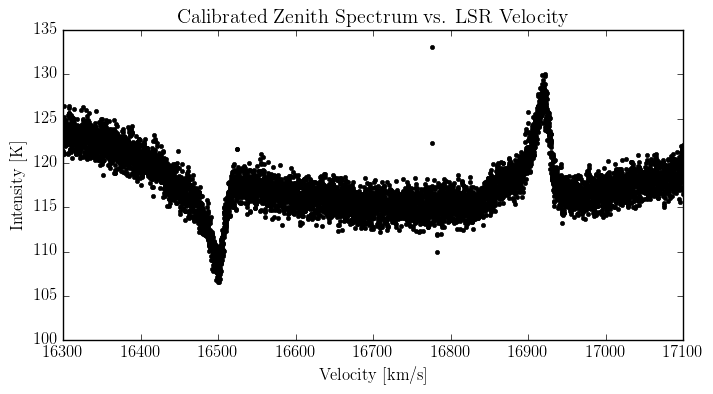

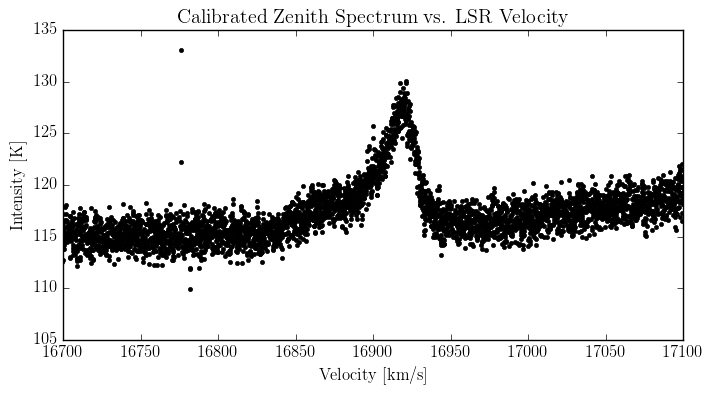

In [132]:
frequency = np.fft.fftfreq(len(T_line), 1/(62.5/8))

c = 299792.458 #km/s
f_0 = 1420.4058 # MHz
velocity = c * (frequency - 0.4058)/f_0

doppler_v = -16861.65812534

plt.figure(figsize=(8,4))
plt.plot((velocity - doppler_v), smooth(T_line), 'k.')
plt.title('Calibrated Zenith Spectrum vs. LSR Velocity')
plt.xlabel('Velocity [km/s]')
plt.ylabel('Intensity [K]')
plt.xlim(16300, 17100)
plt.ylim(100, 135)
plt.show()

plt.figure(figsize=(8,4))
plt.plot((velocity - doppler_v), smooth(T_line), 'k.')
plt.title('Calibrated Zenith Spectrum vs. LSR Velocity')
plt.xlabel('Velocity [km/s]')
plt.ylabel('Intensity [K]')
plt.xlim(16700, 17100)
plt.ylim(105, 135)
plt.show()

# 2.8

x = ugradio.pico.capture_data('50mV', divisor=8, dual_mode=True, nsamples=16000, nblocks=1000, host='10.32.92.95', port=1340, verbose=False)

np.save('cassie', x)

In [39]:
lat = 37.873199 # for Campbell Hall

jd = 2458546.61111 # 18:40 PST, 3/3/2019
lst = ugradio.timing.lst(jd)

v = ugradio.doppler.get_projected_velocity(ra=lst, dec=lat, jd=jd) 

print(v)

[-15047.90968951]


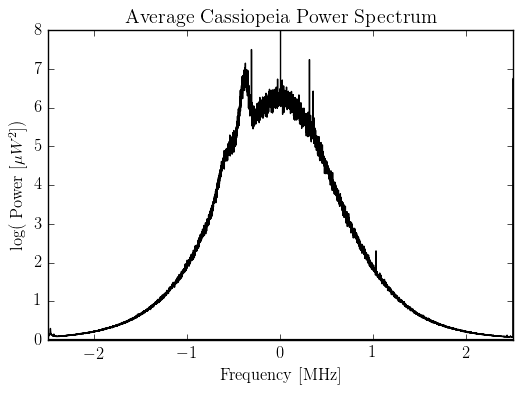

In [116]:
data = np.load('cassie.npy')

P_cassie = avg_ps(data, 1000)
freq = np.fft.fftfreq(len(P_cassie), 1/(62.5/8))
plt.plot(freq, smooth(P_cassie/10**12), 'k')
plt.title('Average Cassiopeia Power Spectrum')
plt.xlabel('Frequency [MHz]')
plt.ylabel('log( Power [\mu W^2] )')
plt.xlim(-2.5, 2.5)
plt.ylim(0, 8)
plt.show()

x = ugradio.pico.capture_data('50mV', divisor=8, dual_mode=True, nsamples=16000, nblocks=1000, host='10.32.92.95', port=1340, verbose=False)

np.save('cassie_upper', x)

Upper LO = 191 MHz

x = ugradio.pico.capture_data('50mV', divisor=8, dual_mode=True, nsamples=16000, nblocks=1000, host='10.32.92.95', port=1340, verbose=False)

np.save('cassie_lower', x)

Lower LO = 189 MHz

In [121]:
upper_data = np.load('cassie_upper.npy')
lower_data = np.load('cassie_lower.npy')

P_upper = avg_ps(upper_data, 1000)
P_lower = avg_ps(lower_data, 1000)

s_line_cassie = P_upper/P_lower
G = 126.34495924 # from section 2.7
T_line_cassie = s_line_cassie * G

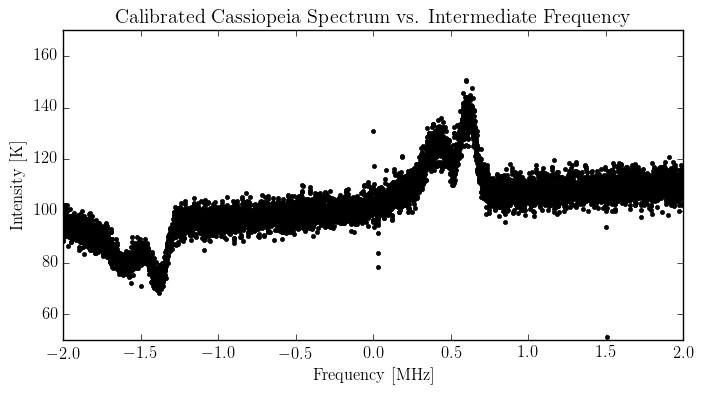

In [131]:
f = np.fft.fftfreq(len(T_line_cassie), 1/(62.5/8))

plt.figure(figsize=(8,4))
plt.plot(f, smooth(T_line_cassie), 'k.')
plt.title('Calibrated Cassiopeia Spectrum vs. Intermediate Frequency')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity [K]')
plt.xlim(-2, 2)
plt.ylim(50, 170)
plt.show()

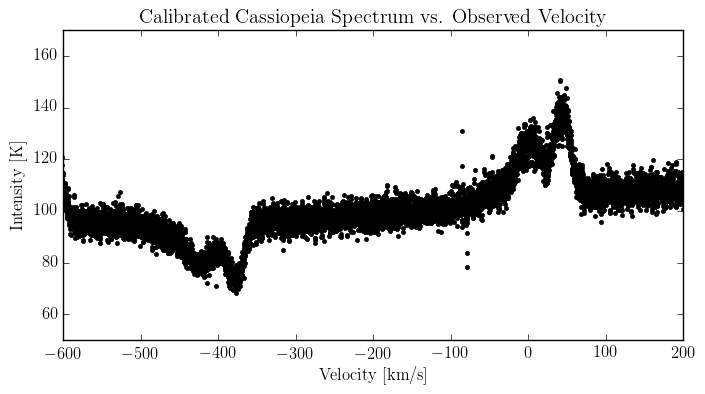

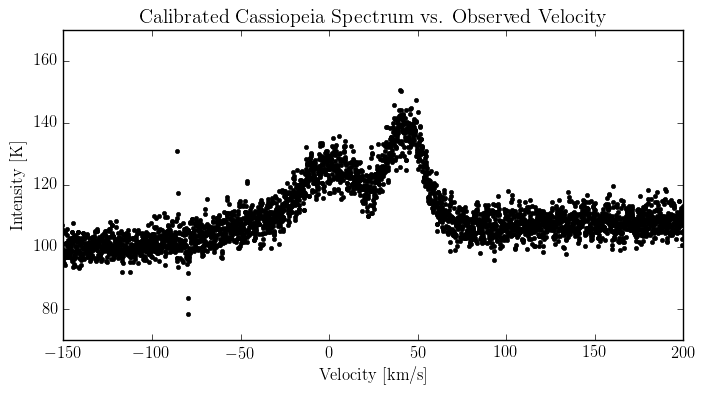

In [239]:
f = np.fft.fftfreq(len(T_line_cassie), 1/(62.5/8))

c = 299792.458 #km/s
f_0 = 1420.4058 # MHz
velocity = c * (f - 0.4058)/f_0

plt.figure(figsize=(8,4))
plt.plot(velocity, smooth(T_line_cassie), 'k.')
plt.title('Calibrated Cassiopeia Spectrum vs. Observed Velocity')
plt.xlabel('Velocity [km/s]')
plt.ylabel('Intensity [K]')
plt.xlim(-600, 200)
plt.ylim(50, 170)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(velocity, smooth(T_line_cassie), 'k.')
plt.title('Calibrated Cassiopeia Spectrum vs. Observed Velocity')
plt.xlabel('Velocity [km/s]')
plt.ylabel('Intensity [K]')
plt.xlim(-150, 200)
plt.ylim(70, 170)
plt.show()

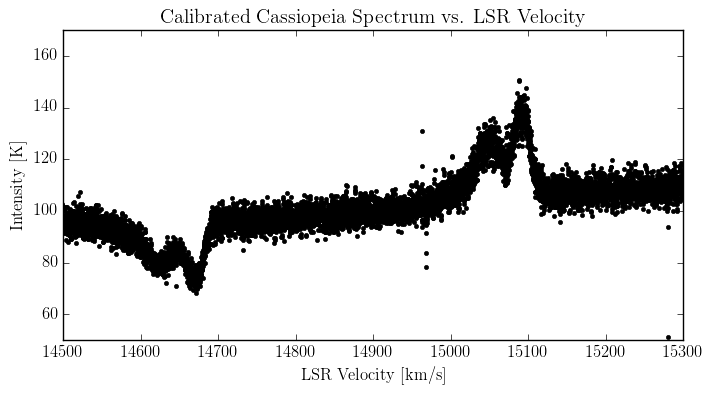

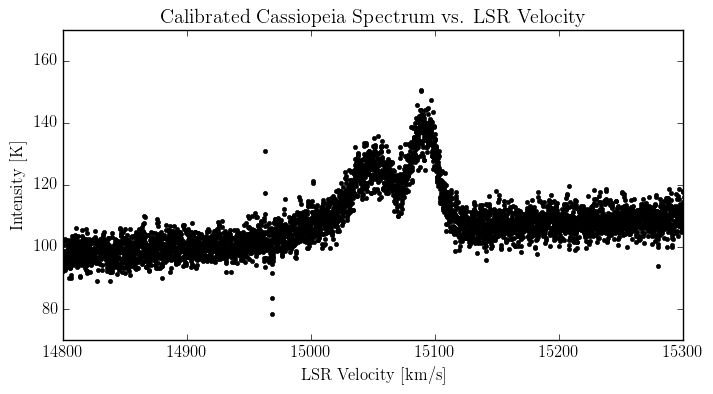

In [238]:
v = -15047.90968951

plt.figure(figsize=(8,4))
plt.plot(velocity - v, smooth(T_line_cassie), 'k.')
plt.title('Calibrated Cassiopeia Spectrum vs. LSR Velocity')
plt.xlabel('LSR Velocity [km/s]')
plt.ylabel('Intensity [K]')
plt.xlim(14500, 15300)
plt.ylim(50, 170)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(velocity - v, smooth(T_line_cassie), 'k.')
plt.title('Calibrated Cassiopeia Spectrum vs. LSR Velocity')
plt.xlabel('LSR Velocity [km/s]')
plt.ylabel('Intensity [K]')
plt.xlim(14800, 15300)
plt.ylim(70, 170)
plt.show()

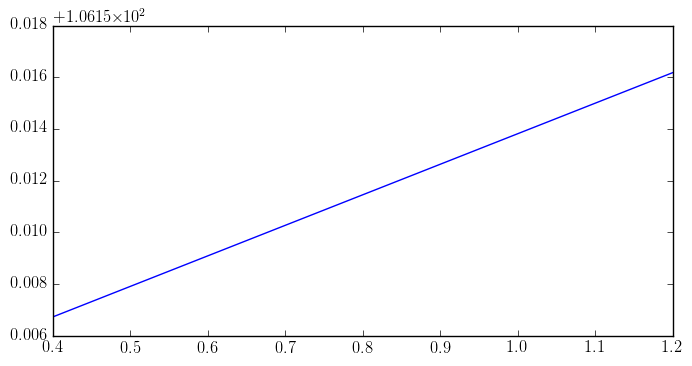

In [209]:
f = np.fft.fftfreq(len(T_line_cassie), 1/(62.5/8))
c = 299792.458 #km/s
f_0 = 1420.4058 # MHz
v = c * (f - 0.4058)/f_0

poly = np.polyfit(v[2000:4000], T_line_cassie[2000:4000], 2)

x = np.linspace(0.4, 1.2, num=16000)
y = poly[0]*x**2 + poly[1]*x + poly[2]

plt.figure(figsize=(8,4))
plt.plot(x, y)
plt.show()

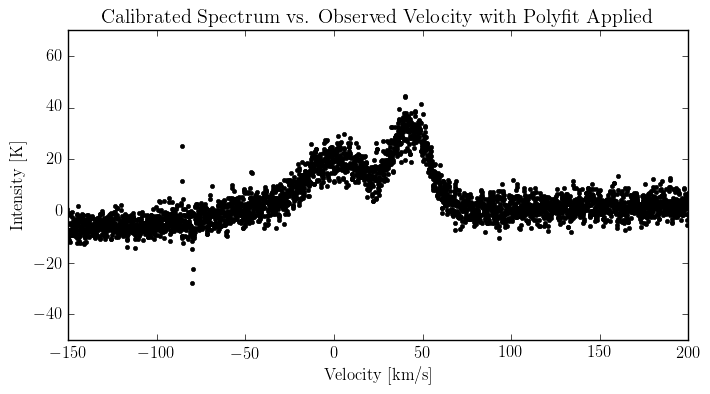

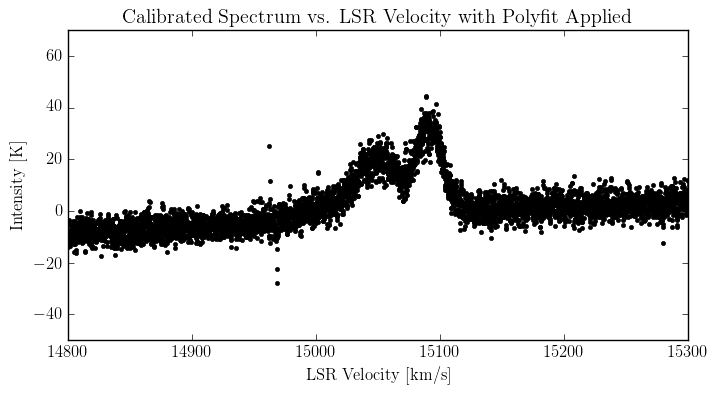

In [236]:
f = np.fft.fftfreq(len(T_line_cassie), 1/(62.5/8))

c = 299792.458 #km/s
f_0 = 1420.4058 # MHz
velocity = c * (f - 0.4058)/f_0

plt.figure(figsize=(8,4))
plt.plot(velocity, smooth(T_line_cassie - y), 'k.')
plt.title('Calibrated Spectrum vs. Observed Velocity with Polyfit Applied')
plt.xlabel('Velocity [km/s]')
plt.ylabel('Intensity [K]')
plt.xlim(-150, 200)
plt.ylim(-50, 70)
plt.show()

v = -15047.90968951
plt.figure(figsize=(8,4))
plt.plot(velocity - v, smooth(T_line_cassie - y), 'k.')
plt.title('Calibrated Spectrum vs. LSR Velocity with Polyfit Applied')
plt.xlabel('LSR Velocity [km/s]')
plt.ylabel('Intensity [K]')
plt.xlim(14800, 15300)
plt.ylim(-50, 70)
plt.show()

In [167]:
import ugradio.gauss as gs

def gaussval(x, amp, avg, sig):
    '''Evaluate a Gaussian given amp, avg, and sig [y = amp * e^(-(x-avg)^2/(2*sig^2)].
    amp/avg/sig can be lists/arrays to simultaneously fit multiple Gaussians.
    Parameters
    ----------
    x : x coordinate at which Gaussian is evaluated
    amp : amplitude(s) of Gaussian(s)
    avg : center point(s) of Gaussian(s)
    sig : width(s) of Gaussian(s)

    Returns
    -------
    y : the evaluated Gaussian [y = amp * e^(-(x-avg)^2/(2*sig^2)]'''
    prms = _pack_prms(amp, avg, sig)
    return _gauss(x, *prms)

In [182]:
gauss = gs.gaussval(0, 50, 50, 50)

print(gauss)

[ 30.32653299]
